In [174]:
!python3 -m pip install mesa

## Imports

In [175]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo


In [176]:
class SIRModelAgent(Agent):
    """
    Representa a un agente o una celda con estado Susceptible (0), Infectado (1), Recuperado (2)
    """
    def __init__(self, unique_id, model):
        """
        Crea un agente con estado inicial de Susceptible, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)
        if np.random.randint(1, 250,dtype=int) == 1:
                self.health_state = 1
        else:
            self.health_state = 0
        
        self.next_state = None

    def step(self):
        """
        Este método es el que calcula el estado de la celda dependiendo el estado de sus vecinos.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True, #Considera también las esquinas, no solo arriba o los lados
            include_center=False)

        infected_neighbours = 0
        for neighbor in neighbours:
            if neighbor.health_state == 1:
                infected_neighbours += 1
        recovered_neighbours = 0
        for neighbor in neighbours:
            if neighbor.health_state == 2:
                recovered_neighbours += 1
            
        self.next_state = self.health_state
        # Modificamos las reglas para interactuar con el entorno
        if self.next_state == 0 and (infected_neighbours > 0):
            if np.random.randint(0, 9,dtype=int) < infected_neighbours:
                self.next_state = 1
        else:
            if self.next_state == 1:
               if np.random.randint(1,200,dtype=int) == 1 or np.random.randint(1, 100,dtype=int) < recovered_neighbours:
                   self.next_state = 2

    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.health_state = self.next_state

class SIRModel(Model):
    """
    Define el modelo de SIR
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True) 
        self.schedule = SimultaneousActivation(self)

        for (content, pos) in self.grid.coord_iter():
            a = SIRModelAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a) 

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector( # Reportero, extraemos los datos que nos interesan
            model_reporters={"Grid": self.get_grid,
                             "Susceptible": self.get_susceptible,
                             "Infected": self.get_infected,
                             "Recovered": self.get_recovered
                             }
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.health_state

        return grid

    def get_susceptible(self):
        total_susceptible_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, SIRModelAgent):
                if agent.health_state == 0:
                    total_susceptible_agents += 1

        return total_susceptible_agents
    
    def get_infected(self):
        total_infected_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, SIRModelAgent):
                if agent.health_state == 1:
                    total_infected_agents += 1

        return total_infected_agents
    
    def get_recovered(self):
        total_recovered_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, SIRModelAgent):
                if agent.health_state == 2:
                    total_recovered_agents += 1

        return total_recovered_agents

# Ejecución del modelo

In [177]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr, iteraciones, cada generacion es "Mejor que la anterior"
NUM_GENERATIONS = 150

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = SIRModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:07.933975


In [178]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [179]:
all_grids

,Grid,Susceptible,Infected,Recovered
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9965,35,0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9940,60,0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9890,110,0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9800,199,1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9696,302,2
...,...,...,...,...
145,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",0,250,9750
146,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",0,230,9770
147,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",0,216,9784
148,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",0,208,9792


In [180]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = []
colors.append(np.array([46 / 255, 179 / 255, 82 / 255, 1]))
colors.append(np.array([97 / 255, 46 / 255, 179 / 255, 1]))
colors.append(np.array([46 / 255, 152 / 255, 179 / 255, 1]))
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=2)

susceptible = []
infected = []
recovered = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])
    susceptible.append(all_grids['Susceptible'].iloc[i])
    infected.append(all_grids['Infected'].iloc[i])
    recovered.append(all_grids['Recovered'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [181]:
anim

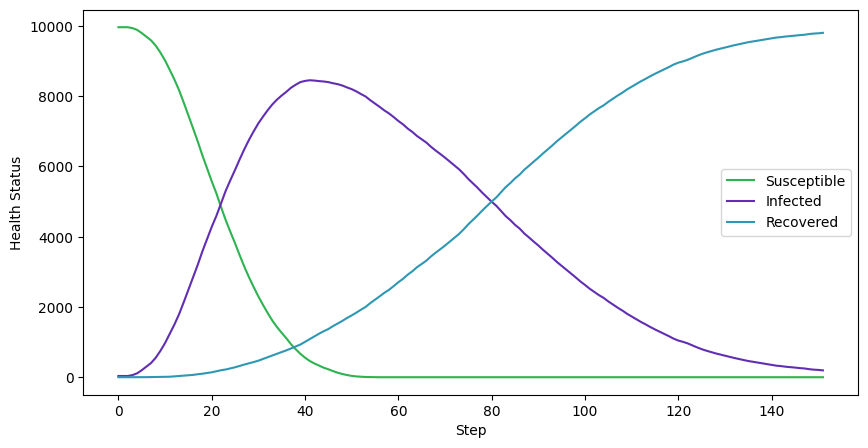

In [182]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Health Status")

plt.plot(susceptible, color='#2eb351', label='Susceptible')
plt.plot(infected, color='#612eb3', label='Infected')
plt.plot(recovered,color='#2e98b3', label='Recovered')
plt.legend()
plt.show()